In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

sns.set_style('whitegrid')
np.random.seed(42)

df = pd.read_csv('in_class_test(in).csv')

print(f"Shape: {df.shape[0]:,} rows x {df.shape[1]} columns")
print(f"Years: {df['Year'].min()}-{df['Year'].max()}")
print(f"Countries: {df['Country'].nunique()}")
print(f"\n{df['Gender'].value_counts()}")
print(f"\nLife Expectancy stats:")
print(df['Life Expectancy'].describe())
print(f"\nMissing: {(df.isnull().sum()/len(df)*100 > 50).sum()} columns >50% null")

Shape: 22,050 rows x 150 columns
Years: 1990-2019
Countries: 281

Gender
Female        7380
Male          7380
Both sexes    7290
Name: count, dtype: int64

Life Expectancy stats:
count    22050.000000
mean        69.011830
std          9.691938
min         24.834000
25%         63.082000
50%         71.134000
75%         76.254000
max         87.747000
Name: Life Expectancy, dtype: float64

Missing: 90 columns >50% null


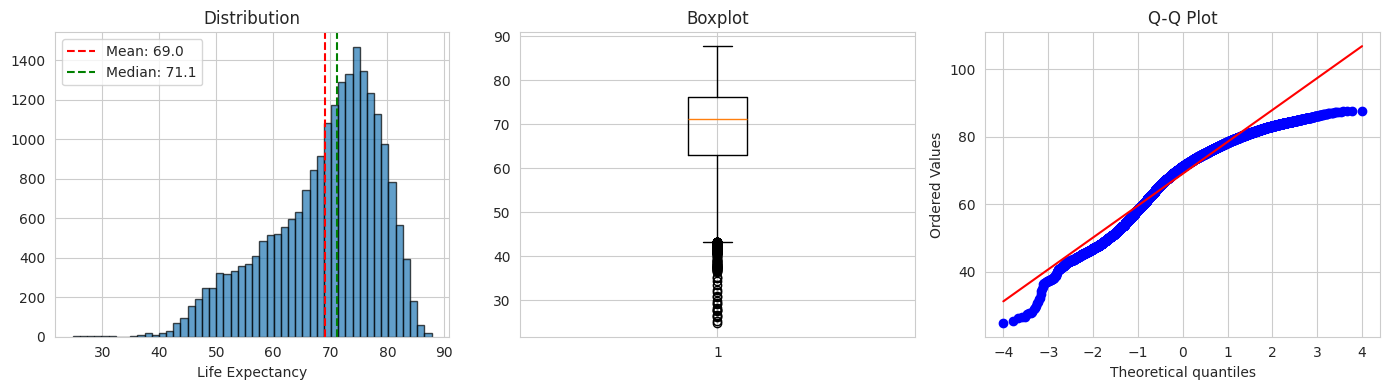

Skewness: -0.759


In [ ]:
# target distribution
fig, axes = plt.subplots(1, 3, figsize=(14, 4))

axes[0].hist(df['Life Expectancy'].dropna(), bins=50, edgecolor='black', alpha=0.7)
axes[0].axvline(df['Life Expectancy'].mean(), color='red', linestyle='--', label=f"Mean: {df['Life Expectancy'].mean():.1f}")
axes[0].axvline(df['Life Expectancy'].median(), color='green', linestyle='--', label=f"Median: {df['Life Expectancy'].median():.1f}")
axes[0].legend()
axes[0].set_xlabel('Life Expectancy')
axes[0].set_title('Distribution')

axes[1].boxplot(df['Life Expectancy'].dropna())
axes[1].set_title('Boxplot')

stats.probplot(df['Life Expectancy'].dropna(), dist="norm", plot=axes[2])
axes[2].set_title('Q-Q Plot')

plt.tight_layout()
plt.show()

print(f"Skewness: {df['Life Expectancy'].skew():.3f}")

Female mean: 71.12
Male mean: 66.17
Gap: 4.94 years
t-stat: 31.62, p-value: 2.35e-212


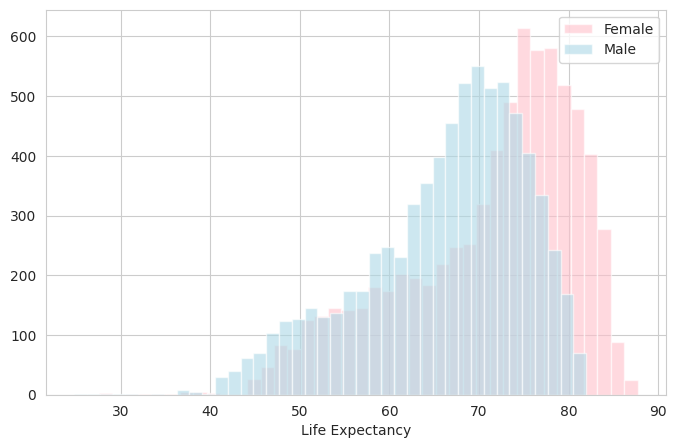

In [ ]:
# gender comparison
female = df[df['Gender'] == 'Female']['Life Expectancy'].dropna()
male = df[df['Gender'] == 'Male']['Life Expectancy'].dropna()

t_stat, p_val = stats.ttest_ind(female, male)
gap = female.mean() - male.mean()

print(f"Female mean: {female.mean():.2f}")
print(f"Male mean: {male.mean():.2f}")
print(f"Gap: {gap:.2f} years")
print(f"t-stat: {t_stat:.2f}, p-value: {p_val:.2e}")

fig, ax = plt.subplots(figsize=(8, 5))
ax.hist(female, bins=40, alpha=0.6, label='Female', color='pink')
ax.hist(male, bins=40, alpha=0.6, label='Male', color='lightblue')
ax.legend()
ax.set_xlabel('Life Expectancy')
plt.show()

In [ ]:
# correlation screening - find strongest predictors
numeric_cols = df.select_dtypes(include=[np.number]).columns
usable = [c for c in numeric_cols if df[c].isnull().sum()/len(df) < 0.5 and c not in ['Year', 'Life Expectancy']]

correlations = df[usable + ['Life Expectancy']].corr()['Life Expectancy'].drop('Life Expectancy')
top_corrs = correlations.abs().sort_values(ascending=False).head(10)

print("Top correlations with Life Expectancy:")
for feat in top_corrs.index:
    print(f"  {feat:<35} r = {correlations[feat]:>7.3f}")

Top correlations with Life Expectancy:
  Infant Mortality Rate               r =  -0.912
  High CI Value Infant Mortality Rate r =  -0.908
  High CI Value Under 5 Mortality Rate r =  -0.904
  Under 5 Mortality Rate              r =  -0.904
  Low CI Value Infant Mortality Rate  r =  -0.901
  Low CI Value Under 5 Mortality Rate r =  -0.890
  Neonatal Mortality Rate             r =  -0.854
  Birth Rate                          r =  -0.847
  Low CI Value Neonatal Mortality Rate r =  -0.836
  High CI Value Neonatal Mortality Rate r =  -0.835


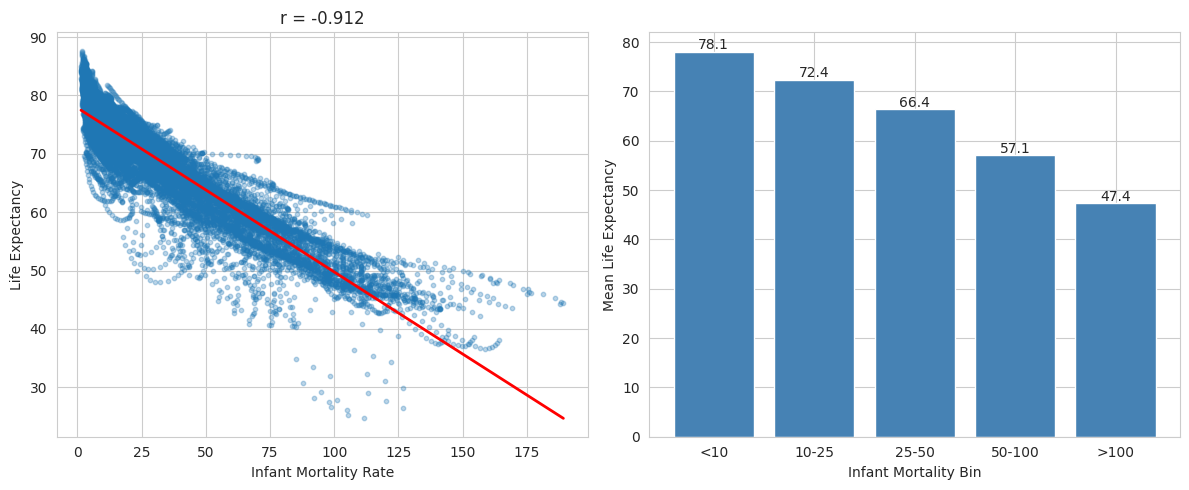

Gap between <10 and >100: 30.7 years


In [ ]:
# infant mortality - strongest predictor
mort_data = df[['Infant Mortality Rate', 'Life Expectancy']].dropna()

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].scatter(mort_data['Infant Mortality Rate'], mort_data['Life Expectancy'], alpha=0.3, s=10)
z = np.polyfit(mort_data['Infant Mortality Rate'], mort_data['Life Expectancy'], 1)
p = np.poly1d(z)
x_line = np.linspace(mort_data['Infant Mortality Rate'].min(), mort_data['Infant Mortality Rate'].max(), 100)
axes[0].plot(x_line, p(x_line), 'r-', lw=2)
axes[0].set_xlabel('Infant Mortality Rate')
axes[0].set_ylabel('Life Expectancy')
axes[0].set_title(f'r = {mort_data.corr().iloc[0,1]:.3f}')

# binned analysis
mort_data['bin'] = pd.cut(mort_data['Infant Mortality Rate'], bins=[0,10,25,50,100,200], labels=['<10','10-25','25-50','50-100','>100'])
bin_means = mort_data.groupby('bin')['Life Expectancy'].mean()
axes[1].bar(bin_means.index, bin_means.values, color='steelblue')
axes[1].set_xlabel('Infant Mortality Bin')
axes[1].set_ylabel('Mean Life Expectancy')
for i, v in enumerate(bin_means.values):
    axes[1].text(i, v+0.5, f'{v:.1f}', ha='center')

plt.tight_layout()
plt.show()

print(f"Gap between <10 and >100: {bin_means['<10'] - bin_means['>100']:.1f} years")

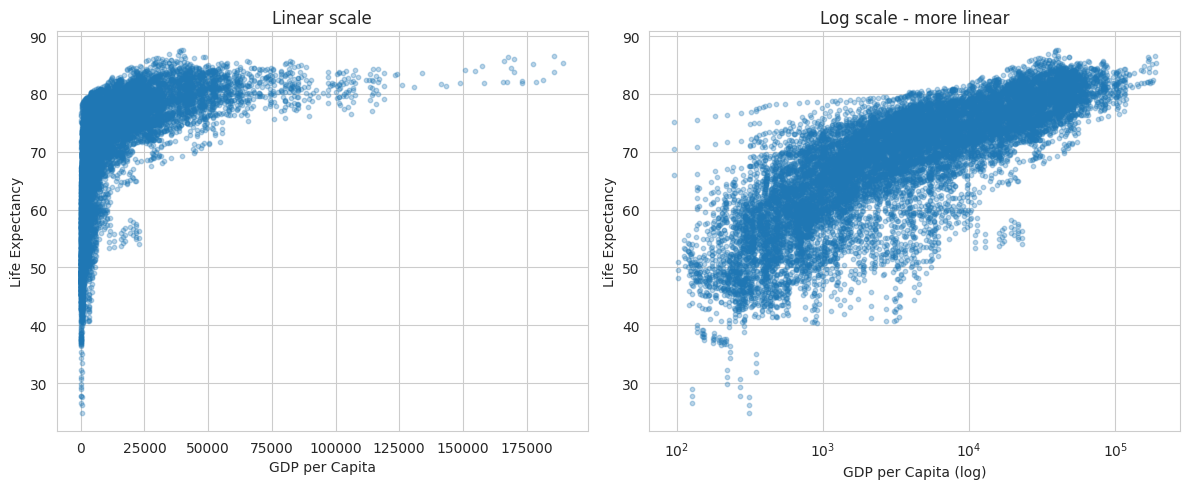

Q1->Q2 gain: 9.6 years
Q3->Q4 gain: 6.1 years
Diminishing returns - need log transform


In [ ]:
# GDP analysis - checking for non-linearity
gdp_data = df[['GDP per Capita', 'Life Expectancy']].dropna()

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].scatter(gdp_data['GDP per Capita'], gdp_data['Life Expectancy'], alpha=0.3, s=10)
axes[0].set_xlabel('GDP per Capita')
axes[0].set_ylabel('Life Expectancy')
axes[0].set_title('Linear scale')

axes[1].scatter(gdp_data['GDP per Capita'], gdp_data['Life Expectancy'], alpha=0.3, s=10)
axes[1].set_xscale('log')
axes[1].set_xlabel('GDP per Capita (log)')
axes[1].set_ylabel('Life Expectancy')
axes[1].set_title('Log scale - more linear')

plt.tight_layout()
plt.show()

# quartile analysis shows diminishing returns
gdp_data['Q'] = pd.qcut(gdp_data['GDP per Capita'], q=4, labels=['Q1','Q2','Q3','Q4'])
q_means = gdp_data.groupby('Q')['Life Expectancy'].mean()
print(f"Q1->Q2 gain: {q_means['Q2'] - q_means['Q1']:.1f} years")
print(f"Q3->Q4 gain: {q_means['Q4'] - q_means['Q3']:.1f} years")
print("Diminishing returns - need log transform")

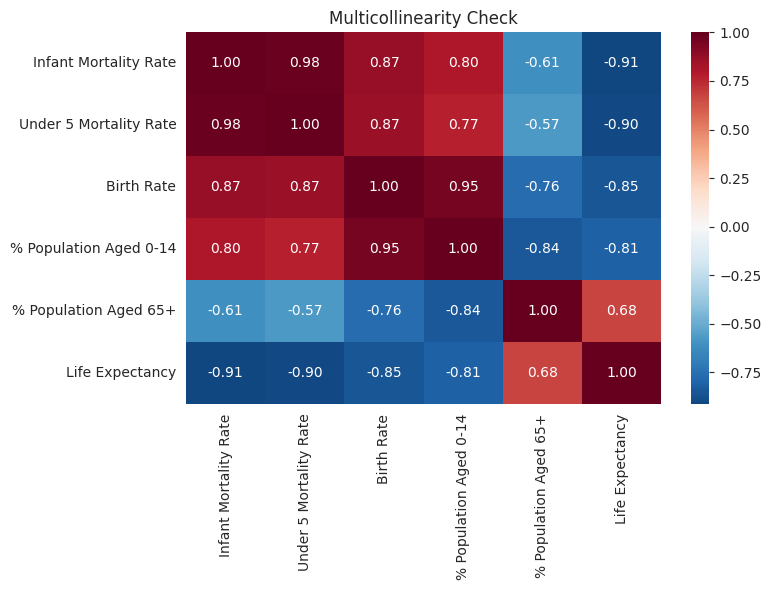


High correlations (potential multicollinearity):
  Infant vs Under-5 Mortality: r = 0.98
  Birth Rate vs % Pop 0-14: r = 0.95

Decision: Keep Infant Mortality (more specific), drop Under-5
Decision: Keep Birth Rate, drop % Pop 0-14


In [ ]:
# multicollinearity check
check_cols = ['Infant Mortality Rate', 'Under 5 Mortality Rate', 'Birth Rate',
              '% Population Aged 0-14', '% Population Aged 65+', 'Life Expectancy']
corr_matrix = df[check_cols].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='RdBu_r', center=0)
plt.title('Multicollinearity Check')
plt.tight_layout()
plt.show()

# flagging problematic pairs
print("\nHigh correlations (potential multicollinearity):")
print(f"  Infant vs Under-5 Mortality: r = {corr_matrix.loc['Infant Mortality Rate', 'Under 5 Mortality Rate']:.2f}")
print(f"  Birth Rate vs % Pop 0-14: r = {corr_matrix.loc['Birth Rate', '% Population Aged 0-14']:.2f}")
print("\nDecision: Keep Infant Mortality (more specific), drop Under-5")
print("Decision: Keep Birth Rate, drop % Pop 0-14")

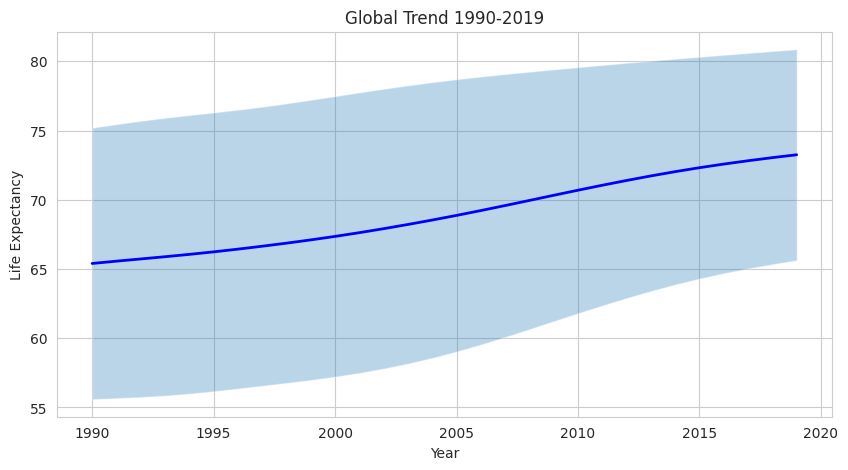

Total improvement: 7.85 years over 30 years


In [ ]:
# temporal trends
yearly = df.groupby('Year')['Life Expectancy'].agg(['mean', 'std'])

plt.figure(figsize=(10, 5))
plt.plot(yearly.index, yearly['mean'], 'b-', lw=2)
plt.fill_between(yearly.index, yearly['mean']-yearly['std'], yearly['mean']+yearly['std'], alpha=0.3)
plt.xlabel('Year')
plt.ylabel('Life Expectancy')
plt.title('Global Trend 1990-2019')
plt.show()

improvement = yearly['mean'].iloc[-1] - yearly['mean'].iloc[0]
print(f"Total improvement: {improvement:.2f} years over 30 years")

In [ ]:
# feature engineering
df_model = df.copy()

df_model['log_GDP'] = np.log1p(df_model['GDP per Capita'])  # log1p handles zeros safely
df_model['Gender_Female'] = (df_model['Gender'] == 'Female').astype(int)
df_model['Gender_Male'] = (df_model['Gender'] == 'Male').astype(int)

# final feature selection - avoiding multicollinear pairs
features = [
    'Infant Mortality Rate',  # chose over Under-5 (r=0.98)
    'Birth Rate',             # chose over % Pop 0-14 (r=0.95)
    'log_GDP',
    '% Population Aged 65+',
    'Gender_Female',
    'Gender_Male',
    'Year'
]

df_final = df_model[features + ['Life Expectancy']].dropna()
print(f"Final dataset: {len(df_final):,} complete cases ({len(df_final)/len(df)*100:.1f}%)")
print(f"Features: {len(features)}")

Final dataset: 12,315 complete cases (55.9%)
Features: 7


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X = df_final[features]
y = df_final['Life Expectancy']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# scale features - fit on train only to prevent leakage
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Train: {X_train.shape[0]:,}")
print(f"Test: {X_test.shape[0]:,}")
print(f"\nTrain mean: {y_train.mean():.2f}, Test mean: {y_test.mean():.2f}")
print("Distribution preserved - ready for modelling")

Train: 9,852
Test: 2,463

Train mean: 68.51, Test mean: 68.47
Distribution preserved - ready for modelling


In [ ]:
print("="*60)
print("KEY FINDINGS")
print("="*60)
print(f"\n1. Infant Mortality strongest predictor (r = -0.91)")
print(f"   30.7 year gap between low (<10) and high (>100) mortality")
print(f"\n2. Gender gap: {gap:.2f} years (females live longer)")
print(f"\n3. GDP shows diminishing returns - log transform needed")
print(f"   Q1->Q2: ~9.6 years, Q3->Q4: ~6.1 years")
print(f"\n4. Temporal improvement: {improvement:.2f} years over 30 years")
print(f"\n5. Multicollinearity handled:")
print(f"   - Infant Mortality kept (Under-5 dropped, r=0.98)")
print(f"   - Birth Rate kept (% Pop 0-14 dropped, r=0.95)")
print("="*60)

KEY FINDINGS

1. Infant Mortality strongest predictor (r = -0.91)
   30.7 year gap between low (<10) and high (>100) mortality

2. Gender gap: 4.94 years (females live longer)

3. GDP shows diminishing returns - log transform needed
   Q1->Q2: ~9.6 years, Q3->Q4: ~6.1 years

4. Temporal improvement: 7.85 years over 30 years

5. Multicollinearity handled:
   - Infant Mortality kept (Under-5 dropped, r=0.98)
   - Birth Rate kept (% Pop 0-14 dropped, r=0.95)


Infant mortality came out as the strongest predictor by a significant margin, which makes sense given it proxies for overall healthcare infrastructure. The multicollinearity between infant and under-5 mortality forced a choice and I went with infant mortality since it's more specific. Log-transforming GDP addressed the diminishing returns pattern visible in the scatter plot. These feature engineering decisions carry through to the model comparison and tie into my assignment argument about why interpretable relationships matter.